In [4]:
import os
import sys

# 1. Get the Project Root (Go up one level from 'notebooks')
project_root = os.path.abspath("..")

# 2. IMPORTANT: Change the working directory to the root
# This ensures that "saved_models/" is found correctly
os.chdir(project_root)
print(f"Working Directory set to: {os.getcwd()}")

# 3. Allow importing from src
if project_root not in sys.path:
    sys.path.append(project_root)

# 4. Now import everything
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset
from src.config import Config

print("Imports successful!")

# 3. Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
model = AutoModelForTokenClassification.from_pretrained(Config.OUTPUT_DIR)
model.to(device)
model.eval()

dataset = load_dataset("lhoestq/conll2003", split="test")
print("Setup Complete.")

Working Directory set to: c:\Users\Sindhu\Desktop\UnknownEntityProject
Imports successful!
Using device: cpu
Setup Complete.


In [5]:
# We will collect vectors and their TRUE labels
vectors = []
labels = []

print("Extracting vectors for visualization...")
# Scan 500 sentences
for i in range(500):
    example = dataset[i]
    inputs = tokenizer(" ".join(example['tokens']), return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    last_hidden_state = outputs.hidden_states[-1].squeeze(0).cpu().numpy()
    word_ids = inputs.word_ids()
    original_tags = example['ner_tags']
    
    for idx, word_id in enumerate(word_ids):
        if word_id is None or word_id >= len(original_tags): continue
        
        tag_id = original_tags[word_id]
        label = Config.ID2LABEL[tag_id]
        
        # We want to plot PER, LOC, MISC, and ORG
        # Ignore 'O' to keep the plot clean
        if label != "O":
            # Simplify labels (B-PER -> PER)
            simple_label = label.split("-")[-1] 
            vectors.append(last_hidden_state[idx])
            labels.append(simple_label)

print(f"Collected {len(vectors)} points.")

Extracting vectors for visualization...
Collected 2714 points.


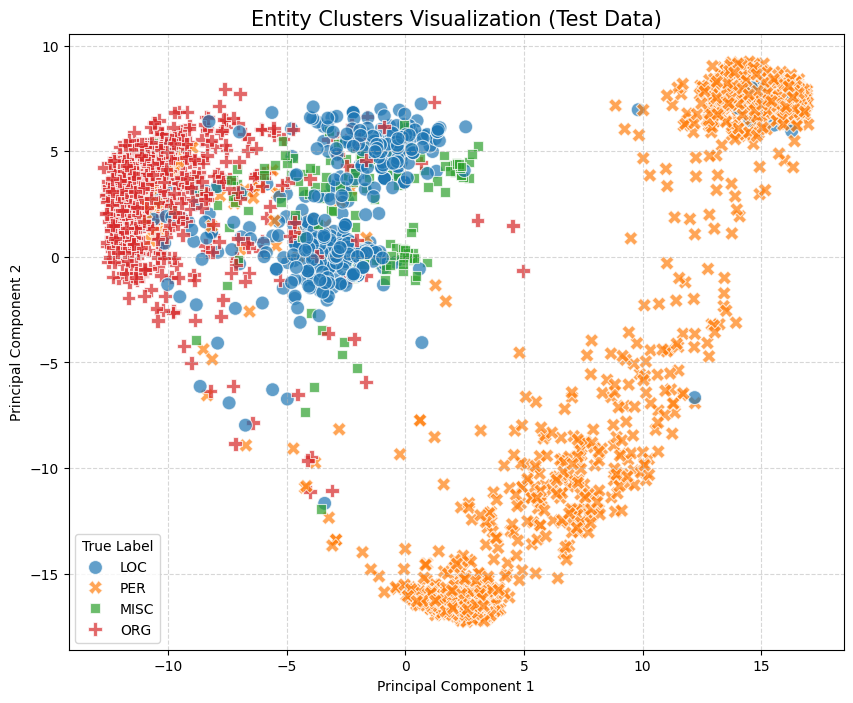

In [6]:
# Reduce dimensions from 768 -> 2 using PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(np.array(vectors))

# Create a DataFrame for Seaborn
df = pd.DataFrame({
    'x': reduced_vectors[:, 0],
    'y': reduced_vectors[:, 1],
    'label': labels
})

# PLOT
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='x', y='y', hue='label', style='label', s=100, alpha=0.7)
plt.title("Entity Clusters Visualization (Test Data)", fontsize=15)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="True Label")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()